## Assignment 3:

The goal is to compare several NLP algorithms for Reuters data – a multi-class classification problem.
 
First, do EDA to understand how many topics (classes) are there in the data. Also understand how many documents
are there in each class. You may want to reduce the number of topics to top 10 or something like that, based
on frequencies.  

In all the experiments, we would hold some parameters constants – truncation of the documents to 128 tokens,
 the batch size to 100, the number of epochs to 10, training split at 15%, same optimizer, same loss function of cross entropy, so that the comparisons are fair.
 
* **EXPERIMENT 1: Fully connected dense neural network**
* EXPERIMENT 2: Simple RNN
* EXPERIMENT 3: LSTM RNN
* EXPERIMENT 4: 1D CNN

`Result`:  Create a table with the accuracy and loss for train/test/validation & process time for all the 4 models.

`Note`: You can tweak several parameters such as dropout, embedding etc. to get more insights.

## Import packages needed (and set seed)

Since Keras in part of TensorFlow 2.x, we import keras from tensorflow and use tenserflow.keras.xxx to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [1]:
import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.2.4-tf'

In [2]:
import numpy as np
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# EXPERIMENT 1

We create a `DNN` model with 3 layers for classifying the Reuters dataset. As, we describe below, if we reduce the number of topics to the "top 9" and train and test our model with the smaller set of images with those labels we get significant better performance.

## The Reuters dataset

We will be working with the `Reuters dataset`, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

Like MNIST and Fashion MNIST, the Reuters dataset comes packaged as part of Keras. 

In [3]:
# https://keras.io/datasets/#reuters-newswire-topics-classification
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=128)

2113536/2110848 [==============================] - 0s 0us/step


The argument `num_words=128` restricts the data to the 128 most frequently occurring words found in the data.

We have 8,982 training examples and 2,246 test examples:

In [4]:
len(train_data), len(train_labels), len(test_data), len(test_labels)

(8982, 8982, 2246, 2246)

Each example is a list of integers (word indices):

In [5]:
print(train_data[1]) 

[1, 2, 2, 2, 2, 56, 2, 2, 9, 56, 2, 2, 81, 5, 2, 57, 2, 2, 2, 20, 2, 7, 2, 49, 2, 2, 2, 2, 2, 2, 8, 7, 10, 2, 16, 2, 2, 2, 2, 5, 4, 2, 2, 2, 2, 2, 7, 48, 34, 2, 44, 35, 2, 2, 17, 12]


In [6]:
max([len(set(lst)) for lst in train_data])

90

In [7]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[1]])
decoded_newswire

557056/550378 [==============================] - 0s 0us/step


'? ? ? ? ? lt ? ? and lt ? ? corp of ? have ? ? ? pct ? in ? company ? ? ? ? ? ? said in a ? it ? ? ? ? of the ? ? ? ? ? in 1986 was ? 5 billion ? ? reuter 3'

In [8]:
len(decoded_newswire.split()) # number words in the newswire

56

## Reducing the number of topics

We find that the top 9 most frequent topics in both the training and test data sets are the same. We create smaller training and testing data sets using only data whose labels are in the top 9. However, since the resulting numerical labels are not contiguous and we don't "fix" the problem. We end up having to use 21 output dimensions for our model. Still we get better performance on the smaller dataset.

**We leave it as an exercise to "relabel" the smaller data set and build and test a `DNN` with only 9 output**

In [9]:
from collections import Counter
len(Counter(list(train_labels)).keys()) # There are 46 topics

46

In [10]:
# The ten most common test labels
from collections import Counter
train_label_tuples = \
Counter(list(train_labels)).most_common(10) # if we keep the top nine we get the same training and test labels
train_label_tuples

[(3, 3159),
 (4, 1949),
 (19, 549),
 (16, 444),
 (1, 432),
 (11, 390),
 (20, 269),
 (13, 172),
 (8, 139),
 (10, 124)]

In [11]:
# The ten most common test labels
from collections import Counter
test_label_tuples = \
Counter(list(test_labels)).most_common(10) # if we keep the top 9 we get the same training and test labels
test_label_tuples

[(3, 813),
 (4, 474),
 (19, 133),
 (1, 105),
 (16, 99),
 (11, 83),
 (20, 70),
 (8, 38),
 (13, 37),
 (25, 31)]

In [12]:
# Separate the the labels from their frequencies
topics_train_tpl, train_freq = zip(*Counter(list(train_labels)).most_common(9))
topics_train_tpl

(3, 4, 19, 16, 1, 11, 20, 13, 8)

In [13]:
train_freq

(3159, 1949, 549, 444, 432, 390, 269, 172, 139)

In [14]:
topics_test_tpl, test_freq = zip(*Counter(list(test_labels)).most_common(9))
topics_test_tpl

(3, 4, 19, 1, 16, 11, 20, 8, 13)

In [15]:
sum(test_freq) # number of test values in top 10

1852

In [16]:
sum(train_freq)  # number of training values in top 10

7503

In [17]:
train_data_sm, train_labels_sm = zip(*((x,y) for x,y in zip(train_data,train_labels) if y in topics_train_tpl))

In [18]:
import numpy as np
train_data_sm, train_labels_sm = np.array(train_data_sm), np.array(train_labels_sm)

In [19]:
len(train_data_sm), len(train_labels_sm)  # matches number of training values in top 10

(7503, 7503)

In [20]:
test_data_sm, test_labels_sm = zip(*((x,y) for x,y in zip(test_data,test_labels) if y in topics_test_tpl))

In [21]:
test_data_sm, test_labels_sm = np.array(test_data_sm), np.array(test_labels_sm)

In [22]:
len(test_data_sm), len(test_labels_sm) # matches number of test values in top 10

(1852, 1852)

In [23]:
Counter(train_labels_sm) # another sanity check on the the new smaller set of training labels. See In [13].

Counter({3: 3159,
         4: 1949,
         16: 444,
         19: 549,
         8: 139,
         11: 390,
         1: 432,
         13: 172,
         20: 269})

In [24]:
Counter(train_labels)

Counter({3: 3159,
         4: 1949,
         16: 444,
         19: 549,
         8: 139,
         21: 100,
         11: 390,
         1: 432,
         13: 172,
         20: 269,
         18: 66,
         25: 92,
         35: 10,
         9: 101,
         38: 19,
         10: 124,
         28: 48,
         2: 74,
         6: 48,
         12: 49,
         7: 16,
         30: 45,
         34: 50,
         15: 20,
         14: 26,
         32: 32,
         41: 30,
         40: 36,
         45: 18,
         23: 41,
         42: 13,
         26: 24,
         24: 62,
         37: 19,
         27: 15,
         31: 39,
         39: 24,
         0: 55,
         22: 15,
         33: 11,
         36: 49,
         17: 39,
         43: 21,
         29: 19,
         44: 12,
         5: 17})

In [25]:
Counter(test_labels_sm) # another sanity check on the the new smaller set of test labels. See In [14].

Counter({3: 813,
         1: 105,
         4: 474,
         11: 83,
         19: 133,
         8: 38,
         20: 70,
         16: 99,
         13: 37})

In [26]:
# https://www.kaggle.com/maximarufo/nlp-classification-reuters-dataset
class_to_idx =  \
{'copper': 6, 'livestock': 28, 'gold': 25, 
 'money-fx': 19, 'ipi': 30, 'trade': 11, 
 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 
 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 
 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 
 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 
 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 
 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 
 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 
 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43, 
 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 
 'hog': 44, 'acq': 4, 'pet-chem': 39, 'grain': 1, 'retail': 29}

In [27]:
idx_to_class = dict([(value, key) for (key, value) in class_to_idx.items()])
{k: idx_to_class[k] for k in list(idx_to_class)[:15]} # get 15 key value pairs

{6: 'copper',
 28: 'livestock',
 25: 'gold',
 19: 'money-fx',
 30: 'ipi',
 11: 'trade',
 0: 'cocoa',
 31: 'iron-steel',
 12: 'reserves',
 26: 'tin',
 37: 'zinc',
 34: 'jobs',
 13: 'ship',
 14: 'cotton',
 23: 'alum'}

In [28]:
# get the dictionary for our smaller data set
idx_to_class_sm = {k:v for k,v in idx_to_class.items() if k in topics_test_tpl}
idx_to_class_sm 

{19: 'money-fx',
 11: 'trade',
 13: 'ship',
 20: 'interest',
 16: 'crude',
 3: 'earn',
 8: 'money-supply',
 4: 'acq',
 1: 'grain'}

In [29]:
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data_sm[16]])
decoded_newswire

'? ? oil co said a ? has been ? to lt ? ? inc for a ? and production ? to be ? in ? bank ? ? in the ? of ? ? ? and ? corp ? ? a ? pct ? ? said its ? oil production co ? will ? the ? which is ? ? to ? 15 000 ? of oil and ? mln ? ? of ? ? the ? is ? ? to be ? in the ? of ? other ? are ? ? corp lt ? with ? ? pct and lt ? ? co of ? with 3 ? pct reuter 3'

In [30]:
idx_to_class_sm[train_labels_sm[16]]   # checking the dictionary...topic seems to be right

'crude'

# Experiment 1:  DNN with 2 layers

We build two version of our model--one with 46 output and one with 21 outputs. So we can compare the performance of the model on the original and reduced datasets. We will see that the latter model will outperform the former. But we might get better performance if we "relabel" the reduced dataset to further reduce the number of outputs to 9.

## Preparing the data

We need to vectorize the sequence into numeric tensors that the neural networks can work with.

In [31]:
train_data_sm.shape, test_data_sm.shape, train_data.shape, test_data.shape

((7503,), (1852,), (8982,), (2246,))

In [32]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.6-classifying-newswires.ipynb
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    
    # Say the the ith sequence = [12, 15, 12, 1], then results[i,squence] = 1 is equivalent to
    # results[12] = 1 (executed twice)
    # results[15] = 1
    # results]1] = 1
    # Consequenlty, the ith row will consist of 1s in columns 1, 12 and 15, and 0s everywhere else
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data for both the original and smaller datasets
train_data_smv = vectorize_sequences(train_data_sm)
train_data_v = vectorize_sequences(train_data)
# Our vectorized test data for both the original and smaller datasets
test_data_smv = vectorize_sequences(test_data_sm)
test_data_v = vectorize_sequences(test_data)

In [33]:
train_data_sm.shape, train_data_smv.shape, test_data_sm.shape, test_data_smv.shape

((7503,), (7503, 10000), (1852,), (1852, 10000))

In [34]:
# summary of the shapes of the training and test data before and after vectorization
train_data.shape, train_data_v.shape, test_data_v.shape, test_data_v.shape

((8982,), (8982, 10000), (2246, 10000), (2246, 10000))

In [35]:
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
from tensorflow.keras.utils import to_categorical

one_hot_train_labels_sm = to_categorical(train_labels_sm)
one_hot_test_labels_sm = to_categorical(test_labels_sm)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [36]:
# shape of the training and test labels after (categorical) vectorization
one_hot_train_labels_sm.shape, one_hot_test_labels_sm.shape

((7503, 21), (1852, 21))

## Building our network


This is a topic classification problem where we reduced the orginal number topics from 46 to 9. However, note that the output dimension is 21 since the categorical values are not contiguous 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an "information bottleneck".

We settle on two hidden layers of dimensions 64 and 32 respectively. Try experimenting with these values to see the effect on performance.


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# To test the effect of reducing the number of topics from 46 to (effectively) 9.

# This is the model to be used with data from all 46 topics
model_full = Sequential()
model_full.add(Dense(64, activation='relu', input_shape=(10000,)))
model_full.add(Dense(32, activation='relu'))
model_full.add(Dense(46, activation='softmax'))

# This is the model we will use with data from the top 9 topics.
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(10000,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(21, activation='softmax'))

There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [38]:
# Compile both models
model_full.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

In the commented code below we set apart 1,000 samples in our training data to use as a validation set. Instead, we set the validation_split (=0.15) when training the model.As an alternative, you can uncomment this code and uncomment: validation_data=(val_data_smv, one_hot_val_labels_sm)).

In [39]:
# val_data_smv = train_data_smv[:1000]
# train_data_smv = train_data_smv[1000:]

# one_hot_val_labels_sm = one_hot_train_labels_sm[:1000]
# one_hot_train_labels_sm = one_hot_train_labels_sm[1000:]

# train_data_v = train_data_v[1000:]

# one_hot_val_labels = one_hot_train_labels[:1000]
# one_hot_train_labels = one_hot_train_labels[1000:]

In [40]:
#val_data_smv.shape, train_data_smv.shape, one_hot_val_labels_sm.shape

In [41]:
#val_data_v.shape, train_data_v.shape, one_hot_val_labels.shape

## Training the model

To get the total training time I used the callback. 

In [42]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

Now let's train both networks for 10 epochs (but without callbacks on the full datasets model):

In [43]:
history_full = model_full.fit(train_data_v,
                    one_hot_train_labels,
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)   

Train on 7634 samples, validate on 1348 samples
Epoch 1/10
7634/7634 [==============================] - 2s 327us/sample - loss: 2.3003 - accuracy: 0.5148 - val_loss: 1.7325 - val_accuracy: 0.5823
Epoch 2/10
7634/7634 [==============================] - 2s 232us/sample - loss: 1.5879 - accuracy: 0.6268 - val_loss: 1.5350 - val_accuracy: 0.6499
Epoch 3/10
7634/7634 [==============================] - 2s 225us/sample - loss: 1.4491 - accuracy: 0.6620 - val_loss: 1.4646 - val_accuracy: 0.6639
Epoch 4/10
7634/7634 [==============================] - 2s 226us/sample - loss: 1.3644 - accuracy: 0.6779 - val_loss: 1.4081 - val_accuracy: 0.6780
Epoch 5/10
7634/7634 [==============================] - 2s 227us/sample - loss: 1.3015 - accuracy: 0.6899 - val_loss: 1.3619 - val_accuracy: 0.6869
Epoch 6/10
7634/7634 [==============================] - 2s 230us/sample - loss: 1.2534 - accuracy: 0.6999 - val_loss: 1.3432 - val_accuracy: 0.6944
Epoch 7/10
7634/7634 [==============================] - 2s 240us

In [44]:
print(f"train_acc: {history_full.history['accuracy'][-1]}, val_acc: {history_full.history['val_accuracy'][-1]}")

train_acc: 0.7177102565765381, val_acc: 0.7040059566497803


In [45]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_data_smv,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                     validation_data=(val_data_smv, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 2s 337us/sample - loss: 1.4496 - accuracy: 0.6167 - val_loss: 0.9765 - val_accuracy: 0.7167
Epoch 2/10
6377/6377 [==============================] - 1s 228us/sample - loss: 0.8445 - accuracy: 0.7580 - val_loss: 0.7850 - val_accuracy: 0.7762
Epoch 3/10
6377/6377 [==============================] - 1s 226us/sample - loss: 0.7155 - accuracy: 0.8027 - val_loss: 0.7048 - val_accuracy: 0.7993
Epoch 4/10
6377/6377 [==============================] - 1s 228us/sample - loss: 0.6557 - accuracy: 0.8204 - val_loss: 0.6737 - val_accuracy: 0.8135
Epoch 5/10
6377/6377 [==============================] - 1s 229us/sample - loss: 0.6203 - accuracy: 0.8288 - val_loss: 0.6567 - val_accuracy: 0.8126
Epoch 6/10
6377/6377 [==============================] - 1s 230us/sample - loss: 0.5992 - accuracy: 0.8363 - val_loss: 0.7084 - val_accuracy: 0.7904
Epoch 7/10
6377/6377 [==============================] - 1s 231us

In [46]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

15.537714

In [47]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.8420887589454651, val_acc: 0.8250443935394287


## Testing the model

We test both models and get the runtime of the model classifying 9 topics using callbacks. Again, the model with less classes has better performance.

In [48]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [49]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt])

1852/1852 [==============================] - 0s 158us/sample - loss: 0.6758 - accuracy: 0.8089


In [50]:
# Note the original model evaluating the data with 46 topics performs worse on the test data
test_loss, test_accuracy = model_full.evaluate(test_data_v, one_hot_test_labels)
#print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

2246/2246 [==============================] - 0s 150us/sample - loss: 1.2993 - accuracy: 0.6808


In [51]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.293083

In [52]:
history_dict = history.history
history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_dict.keys()

dict_keys(['loss', 'val_loss', 'val_accuracy', 'train_accuracy'])

In [53]:
import pandas as pd
history_df=pd.DataFrame(history_dict)
history_df['test_accuracy'] = test_accuracy
history_df = history_df.iloc[-1:]
history_df.tail()

,loss,val_loss,val_accuracy,train_accuracy,test_accuracy
9,0.554613,0.640314,0.825044,0.842089,0.680766


In [54]:
# This takes a bit of time to execute...
#class_values = ([np.argmax(model.predict(test_data_smv[x].reshape(1,10000))) for x in range(0,1852)])

In [55]:
# from collections import Counter
# Counter(class_values).most_common()

## Saving the performance to a DataFrame

Let us now create the DataFrame with statistics. Note that we only need the last row of history_df.

In [56]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (2 layers)') # want the model name to appear first
results_df['test_accuracy'] = test_accuracy
results_df['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df

,model,loss,val_loss,val_accuracy,train_accuracy,test_accuracy,training time (sec),testing time (sec)
9,DNN (2 layers),0.554613,0.640314,0.825044,0.842089,0.680766,15.537714,0.293083


## Plotting the performance 

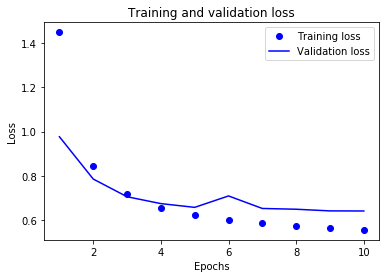

In [57]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

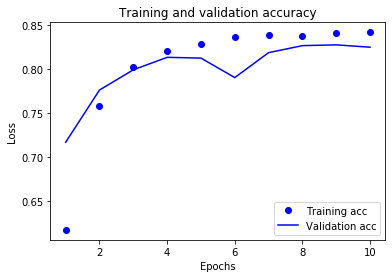

In [58]:
plt.clf()   # clear figure

acc = history.history['train_accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Establishing a baseline
"This approach reaches an accuracy of ~81%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%. But in this case it’s closer to 26%, so the results seem pretty good, at least when compared to a random baseline:" 

See https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.6-classifying-newswires.ipynb

In [59]:
import copy

test_labels_sm_copy = copy.copy(test_labels_sm)
np.random.shuffle(test_labels_sm_copy)
float(np.sum(np.array(test_labels_sm) == np.array(test_labels_sm_copy))) / len(test_labels_sm)
# test_labels_copy = copy.copy(test_labels)
# np.random.shuffle(test_labels_copy)
# float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.26187904967602593

## Adding dropout

In [60]:

from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(10000,)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(21, activation='softmax'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_rt = TrainRuntimeCallback()
history = model.fit(train_data_smv,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.25)  

Train on 5627 samples, validate on 1876 samples
Epoch 1/10
5627/5627 [==============================] - 2s 359us/sample - loss: 1.7192 - accuracy: 0.5966 - val_loss: 1.0662 - val_accuracy: 0.6994
Epoch 2/10
5627/5627 [==============================] - 2s 302us/sample - loss: 0.9979 - accuracy: 0.7030 - val_loss: 0.8849 - val_accuracy: 0.7564
Epoch 3/10
5627/5627 [==============================] - 1s 242us/sample - loss: 0.8335 - accuracy: 0.7601 - val_loss: 0.7355 - val_accuracy: 0.7990
Epoch 4/10
5627/5627 [==============================] - 1s 245us/sample - loss: 0.7441 - accuracy: 0.7923 - val_loss: 0.7520 - val_accuracy: 0.7804
Epoch 5/10
5627/5627 [==============================] - 1s 244us/sample - loss: 0.6904 - accuracy: 0.8066 - val_loss: 0.6779 - val_accuracy: 0.7974
Epoch 6/10
5627/5627 [==============================] - 1s 247us/sample - loss: 0.6558 - accuracy: 0.8173 - val_loss: 0.6475 - val_accuracy: 0.8246
Epoch 7/10
5627/5627 [==============================] - 1s 250us

In [61]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

14.811407

In [62]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt]) 
#print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

1852/1852 [==============================] - 0s 157us/sample - loss: 0.6606 - accuracy: 0.8062


In [63]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.291925

## Saving the performance to a DataFrame

Add a row to results_df with the performance statistics.

In [64]:
history_dict = history.history
history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','DNN (2 layers) w Drop') # want the model name to appear first
df['test_accuracy'] = test_accuracy
df['training time (sec)'] = train_time      # we are okay with training time appearing last
df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df = results_df.append(df, ignore_index = True)
results_df

,model,loss,val_loss,val_accuracy,train_accuracy,test_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.554613,0.640314,0.825044,0.842089,0.680766,15.537714,0.293083
1,DNN (2 layers) w Drop,0.582360,0.606016,0.835288,0.838457,0.806156,14.811407,0.291925


## Adding an Embedding layer

Instead of using `vectorize_sequences` to vectorize our input data, we rely on an `Embedding layer` to learn the best vectorization.

In [65]:
train_data_smv.shape

(7503, 10000)

In [66]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb

from tensorflow.keras import preprocessing


train_data_smv = preprocessing.sequence.pad_sequences(train_data_sm, maxlen=80)
test_data_smv = preprocessing.sequence.pad_sequences(test_data_sm, maxlen=80)

In [67]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb
from tensorflow.keras.layers import Flatten, Embedding

model = Sequential()

# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 128, input_length = 80))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 30)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 30)`
model.add(Flatten())


# We add the classifier on top
model.add(Dense(21, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 128)           1280000   
_________________________________________________________________
flatten (Flatten)            (None, 10240)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 21)                215061    
Total params: 1,495,061
Trainable params: 1,495,061
Non-trainable params: 0
_________________________________________________________________


In [68]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_data_smv,             
                    one_hot_train_labels_sm,  
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 2s 301us/sample - loss: 1.5681 - accuracy: 0.4855 - val_loss: 1.3127 - val_accuracy: 0.5719
Epoch 2/10
6377/6377 [==============================] - 1s 184us/sample - loss: 1.1805 - accuracy: 0.5838 - val_loss: 1.1391 - val_accuracy: 0.6030
Epoch 3/10
6377/6377 [==============================] - 1s 183us/sample - loss: 0.9851 - accuracy: 0.6668 - val_loss: 1.0152 - val_accuracy: 0.6661
Epoch 4/10
6377/6377 [==============================] - 1s 180us/sample - loss: 0.8344 - accuracy: 0.7413 - val_loss: 0.9751 - val_accuracy: 0.7052
Epoch 5/10
6377/6377 [==============================] - 1s 184us/sample - loss: 0.7201 - accuracy: 0.7856 - val_loss: 0.9420 - val_accuracy: 0.7025
Epoch 6/10
6377/6377 [==============================] - 1s 184us/sample - loss: 0.6260 - accuracy: 0.8255 - val_loss: 0.9553 - val_accuracy: 0.6963
Epoch 7/10
6377/6377 [==============================] - 1s 201us

In [69]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt])
test_loss, test_accuracy

1852/1852 [==============================] - 0s 100us/sample - loss: 0.9928 - accuracy: 0.6998


(0.9928313910832416, 0.69978404)

In [70]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.186145

## Plotting the performance 

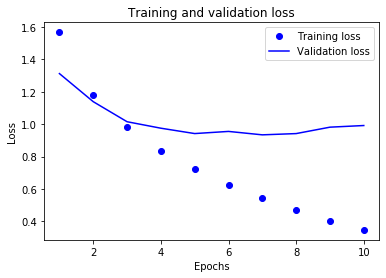

In [71]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

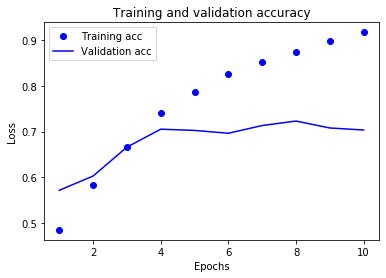

In [72]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [73]:
#del history_dict

In [74]:
#history.history

## Saving the performance to a DataFrame

Add a row to results_df with the performance statistics.

In [75]:
history_dict = history.history.copy()
history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','DNN (2 layers) w Embed') # want the model name to appear first
df['test_accuracy'] = test_accuracy
df['training time (sec)'] = train_time      # we are okay with training time appearing last
df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df = results_df.append(df, ignore_index = True)
results_df

,model,loss,val_loss,val_accuracy,train_accuracy,test_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.554613,0.640314,0.825044,0.842089,0.680766,15.537714,0.293083
1,DNN (2 layers) w Drop,0.582360,0.606016,0.835288,0.838457,0.806156,14.811407,0.291925
2,DNN (2 layers) w Embed,0.346561,0.991676,0.703375,0.916575,0.699784,14.811407,0.186145


## Saving to a DataFrame to disk

Save the DataFrame for use in part 2.

In [76]:
results_df.to_pickle("results1.pkl") 